### Need to generate Adult Data and pass it in self.data
<ul>
    <li> <del>environment virtuel python sur cedar
    <li> <del>Make sure GPU is used
    <li><del> Need ask best params from Rosin</li>
    <li> <del>run Adult
    <li> <del> make sure toSave data from PreProcessing somewhere
    <li> <del>Wrap to take two csv of corresponding original (label)
    <li> <del>Code test testing loop
    <li> <b>What to use as test loss and final metric</b>
    <li> <del>Same Encoding for labels and training data
    <li> 
</ul>


### Imports

In [1]:
# # Imports
import utilities as utils
# import datasets as d

# from Stats import Plots as Pl
import tqdm
import time
import yaml
import json
import torch
import random
import os.path
import warnings
import importlib
import torchvision
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from typing import List
from torch.utils.data import *
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils import data as td
from joblib import Parallel, delayed

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CPU_DEVICE = torch.device("cpu")
GET_VALUE = lambda x: x.to(CPU_DEVICE).data.numpy().reshape(-1)[0]
print(f"\n *** \n Currently running on {device}\n *** \n")


 *** 
 Currently running on cpu
 *** 



In [2]:

# Data import & Pre-processing
  
class My_dataLoader:
    def __init__(self, batch_size : int, data_path :str, label_path:str, n_train :int,  label_col_name:str, test_batch_size:int=128):
        '''
            Creates train and test loaders from local files, to be easily used by torch.nn
            
            :batch_size: int for size of training batches
            :data_path: path to csv where data is. 2d file
            :label_path: csv containing labels. line by line equivalent to data_path file
            :n_train: int for the size of training set (assigned randomly)
            :test_batch: size of batches at test time. If none, will be same 
                    as training
            :label_col_name name of columns that contains labels
        '''
        self.batch_size = batch_size
        self.train_size = n_train
        self.test_batch = test_batch_size
        
        df_data = pd.read_csv(data_path)
        df_label = pd.read_csv(label_path)
        
        a = df_data.values
        b = df_label.values
        self.data = torch.tensor(a[:,:]) # where data is 2d [D_train_size x features]
        self.labels = torch.tensor(b[:,:]) # also has too be 2d
        
        self.local_dataset = torch.utils.data.TensorDataset(self.data, self.labels)
                     
        #custom_transform = transforms.Normalize((mean_mean,), (std_mean,)) 
        
        
        indices = list(range(len(self.local_dataset)))
        random.shuffle(indices)
        
        # Split dataset into train and Test sets
        self.train_loader = torch.utils.data.DataLoader(
            self.local_dataset,
            batch_size=self.batch_size,
            sampler=SubsetRandomSampler(indices[:self.train_size]),
            num_workers=1,
            pin_memory=False
        )

        self.test_loader = DataLoader(
            self.local_dataset,
            batch_size=self.test_batch,
            sampler=SubsetRandomSampler(indices[self.train_size:]),
            num_workers=1,
            pin_memory=False
        )

class PreProcessing:
    def __init__(self, params_file: str):
        '''
            Imports all variables/parameters necessary for preparation of training.
            Looks into params.yaml, then creates dataloader that can be used
            
            params_file: path to file that contains parameters.
                            Needs to follow a specific naming and format
        '''
        # Import params
        stream = open(params_file, 'r')
        self.params = yaml.load(stream, yaml.FullLoader)

        import_path = self.params['data_loading']['data_path']['value']
        label_path = self.params['data_loading']['label_path']['value']

        batchSize = self.params['model_params']['batchSize']['value']
        test_batch_size = self.params['model_params']['test_batch_size']['value']
        percent_train_set = self.params['model_params']['percent_train_set']['value']


        df2 = pd.read_csv(import_path)
        df_labels = pd.read_csv(label_path)
        n_test = int(len(df2.iloc[:,0])*percent_train_set)

        if df2.shape != df_labels.shape:
            print(df2.shape)
            print(df_labels.shape)
            raise ValueError("The labels csv and data csv don't have the same shape.")
        
        data_cat_list = utils.find_cat(df2)
        label_cat_list = utils.find_cat(df_labels)
        
        if data_cat_list != label_cat_list:
            raise ValueError('The categorical data columns found in your data doesnt match the ones found in your labels.\n That means the AE will learn on data that is encoded differently from the labels it tries to immitate.') 
       
        
        if len(data_cat_list) > 0:
            print(f"Categorical variable found. Running Pandas dummy_variable encoding on {len(data_cat_list)} columns \n")
            df_data = utils.dummy_encode(df2, data_cat_list)
            df_labels = utils.dummy_encode(df_labels, label_cat_list)
            print(f"Saving output dataset under {import_path[:-4]}_NoCat.csv \n")
            df_data.to_csv(f"{import_path[:-4]}_NoCat.csv", index=False)
            
            df_data, df_labels = utils.adjust_enc_errors(df_data, df_labels)
            if df_data.shape != df_labels.shape:
                print(df_data.shape)
                print(df_labels.shape)
#                 import pdb;pdb.set_trace()
                raise ValueError("The labels csv and data post-encoding don't have the same shape.")
                
            df_labels.to_csv(f"{label_path[:-4]}_NoCat.csv", index=False)
            self.dataloader = My_dataLoader(batchSize, f"{import_path[:-4]}_NoCat.csv", f"{label_path[:-4]}_NoCat.csv", n_test, "income", test_batch_size)
        
        else: # no categorical vars found
            self.dataloader = My_dataLoader(batchSize, import_path, n_test, "income", test_batch_size)
        
        # Save data somewhere
#         1 - make dir inside experimetns with copy of params.yaml
#         2- dump json with other info in there
#         dataset_name = data['data_loading']['path']['value'].split('/')[-1]
        
#         with open(f'./experiments/{dataset_name}_{}.txt', 'w') as file:
#              file.write(json.dumps(exDict))
        

In [3]:
experiment_x = PreProcessing("params.yaml")

Categorical variable found. Running Pandas dummy_variable encoding on 7 columns 

Saving output dataset under ../GeneralDatasets/sanitizer_output/Adult/adult_5k_20ep/SubExp_1/full_a=0_E=19_NoCat.csv 



### Training

In [4]:
# Box

class autoencoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Sigmoid(), nn.Linear(8, 4))#, nn.ReLU(True), nn.Linear(4, 4))
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.Sigmoid(),
#             nn.Linear(10, 16),
#             nn.ReLU(True),
            nn.Linear(16, 24),
            nn.Sigmoid(), nn.Linear(24, out_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


def train(model,train_loader, optimizer, epoch, loss_fn):
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
      
        #inputs = inputs.view(batchSize, 1,100,100)
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(inputs.float())
        loss = loss_fn(output.float(), target.float())
        
        # Backprop
        loss.backward()
        optimizer.step()
        ###
        
#         if batch_idx % 10 == 0:
#                print('Train Epoch Loss: {:.6f}'.format(loss.item()))

def test(model, test_loader, test_loss_fn):
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
          
            #inputs = inputs.view(batchSize, 1,100,100)
            inputs, target = inputs.to(device), target.to(device)
            
            
            output = model(inputs.float())
            test_size += len(inputs.float())
            test_loss += test_loss_fn(output.float(), target.float()).item() 
            pred = output.max(1, keepdim=True)[1] 

    test_loss /= test_size
#     print('Test set: Average loss: {:.4f} \n'.format(
#         test_loss))
    
    return test_loss

In [ ]:
start = time.time()
wd = experiment_x.params['model_params']['weight_decay']['value']
learning_rate = experiment_x.params['model_params']['learning_rate']['value']

num_epochs = int(experiment_x.params['model_params']['num_epochs']['value'])

#######
in_dim = experiment_x.dataloader.data.shape[1]
out_dim = experiment_x.dataloader.labels.shape[1]
#######


model = autoencoder(in_dim, out_dim).to(device)
train_loss = torch.nn.L1Loss().to(device) # BCEWithLogitsLoss combines sig, so no need activate out layer with softmax
test_loss_fn =torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
test_accuracy = []

for epoch in range(num_epochs):
    for data in experiment_x.dataloader.train_loader:

        train(model,experiment_x.dataloader.test_loader, optimizer, epoch, train_loss)

        
        # TODO: NEED TEST SET
        loss = test(model, experiment_x.dataloader.test_loader, test_loss_fn)

    test_accuracy.append(loss)
    # ===================log========================
#     if epoch % 20 ==0:
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss))
    

a =experiment_x.params['data_loading']['data_path']['value'][36:].split('/')[0]

fm = open(f"./experiments/{str.replace(time.ctime(), ' ', '_')}-{a}.pth", "wb")
torch.save(model.state_dict(), fm)

with open(f"./experiments/{str.replace(time.ctime(), ' ', '_')}-{a}.txt", 'w+') as f:
    f.write(f"Epochs: {num_epochs} \n")
    f.write(f"Learning Rate: {learning_rate} \n")
    f.write(f"weight decay: {wd}\n")
    f.write(f"Training Loss: {str(train_loss)}\n")
    f.write(f"Test Loss: {str(test_loss_fn)} \n")
    f.write(f"Optimizer: {str(optimizer)}\n")

end = time.time()
print(f"Training on {num_epochs} epochs completed in {(end-start)/60} seconds.")

epoch [1/5], loss:26.8447


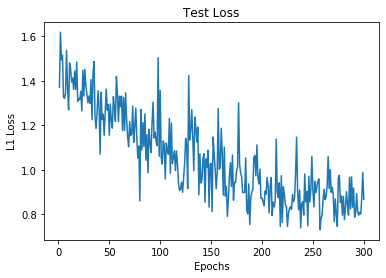

In [8]:
plt.plot(np.arange(1,num_epochs+1), np.array(test_accuracy))
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.title("Test Loss")
plt.savefig(f"./experiments/{str.replace(time.ctime(), ' ', '_')}-{a}_test-loss.png")
plt.show()